In [1]:
% matplotlib inline
print("Hello, HW 01!")

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

Hello, HW 01!


## kNN

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist


def prepare_data_notnorm(filename='spambase.csv'):
    df = pd.read_csv(filename)
    objects, labels = df.iloc[:, :-1], df.iloc[:, -1]
    return objects, labels


def extract_data(objects, labels):
    split = 0.67  # industrial standart ?

    msk = np.random.rand(objects.shape[0]) < split

    trainingObj = objects[msk]
    trainigLabels = labels[msk]

    testObj = objects[~msk]
    testLabels = labels[~msk]

    return trainingObj, trainigLabels, testObj, testLabels


# return accuracy
def classify(trainingObj, trainingLabels, testObj, testLabels, k) -> float:
    assert k >= 0 and trainingObj is not None

    from scipy.spatial.distance import cdist

    # dist between every points
    dists = cdist(testObj, trainingObj)

    # from every row of distances get indices of k smallest distances
    idx = np.argpartition(dists, k, axis=1)[:, :k]

    # Labels - training spam / not spam
    trainingLabels = trainingLabels.values.reshape(trainingLabels.shape[0])
    #     trainingLabels

    # Lables для 3х ближайших соседей
    nearest_dists = np.take(trainingLabels, idx)
    #     nearest_dists

    # Number of label=1 among all neigbours for every testObject
    counted = nearest_dists.sum(axis=1)
    #     counted

    predicted = np.array((counted > k / 2), dtype=int)
    #     predicted

    accuracy = np.equal(predicted, testLabels).sum() / testLabels.shape[0]

    return accuracy


################
def simple_kNN(objects, labels):
    trainingObj, trainigLabels, testObj, testLabels = extract_data(objects,
                                                                   labels)

    ks = [k for k in range(1, 11)]
    accuracy = []

    for k in ks:
        acc = classify(trainingObj, trainigLabels, testObj, testLabels, k)
        accuracy.append(acc)

    return ks, accuracy


#### inteface ###
def kNN_not_normalized():
    objects, labels = prepare_data_notnorm()
    x, y = simple_kNN(objects, labels)

    plt.ylabel('LOO')
    plt.xlabel('K')

    red_patch = mpatches.Patch(color='red', label='kNN not normalizaed')
    plt.legend(handles=[red_patch])

    plt.plot(x, y, label='kNN not normalizaed', color='red')
    plt.show()

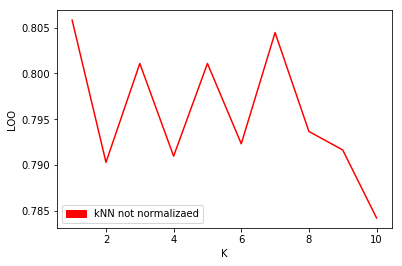

In [3]:
kNN_not_normalized()

### Normalized kNN

In [4]:
def prepare_data_norm(filename='spambase.csv'):
    df = pd.read_csv(filename)
    objects, labels = df.iloc[:, :-1], df.iloc[:, -1]
    
    def normalizer(s):
        return (s - s.min())/(s.max() - s.min())

    return objects.apply(normalizer, axis=0), labels

#### inteface ###
def kNN_normalized():
    objects, labels = prepare_data_norm()
    x, y = simple_kNN(objects, labels)

    plt.ylabel('LOO')
    plt.xlabel('K')
    lb = 'kNN normalizaed'
    
    red_patch = mpatches.Patch(color='blue', label=lb)
    plt.legend(handles=[red_patch])


    plt.plot(x, y, label=lb, color='blue')
    plt.show()    
    

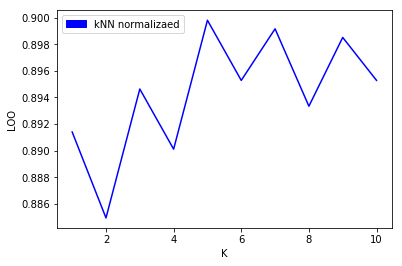

In [5]:
kNN_normalized()

## Radius 
### Not normalized
Тернарный поиск после, внизу.

In [6]:
# return accuracy
def classify_radius(trainingObj, trainingLabels, testObj, testLabels,
                    r) -> float:
    assert r >= 0 and trainingObj is not None

    from scipy.spatial.distance import cdist

    # dist between every points
    dists = cdist(testObj, trainingObj)

    # соседей в радиусе для каждой точке
    vert_in_radius = (dists < r).sum(axis=1)

    # разможим trainigLabels чтобы дальше считать без циклов для каждой
    # тестовой вершины
    trainLabelsRep = (
        trainingLabels.repeat(dists.shape[0]).values.reshape(dists.shape[1],
                                                             dists.shape[0])).T

    # для каждого теста - сколько соседей c label=1 имеют одна тестова вершина
    labels1_for_each_test = np.logical_and(trainLabelsRep, dists < r).sum(
        axis=1)

    predicted = np.array(labels1_for_each_test > (vert_in_radius / 2),
                         dtype=int)

    accuracy = np.equal(predicted, testLabels).sum() / testLabels.shape[0]

    return accuracy


################
def radius_kNN(objects, labels, r, maximum, step, verbose=True):
    trainingObj, trainigLabels, testObj, testLabels = extract_data(objects,
                                                                   labels)

    if verbose:
        dists = cdist(testObj, trainingObj)
        print("min dist = " + repr(np.min(dists)))
        print("max dist = " + repr(np.max(dists)))
    
    rs = []
    accuracy = []    

    while r <= maximum:
        acc = classify_radius(trainingObj, trainigLabels, testObj, testLabels,
                              r)
        accuracy.append(acc)
        rs.append(r)
        r += step

    return rs, accuracy


#### inteface ###
def kNN_radius_not_normalized(r = 1.0, maximum = 300.0, step = 7.0):
    objects, labels = prepare_data_notnorm()
    x, y = radius_kNN(objects, labels, r, maximum, step)
    
    print()
    print("max acc = " + repr(max(y)))

    plt.ylabel('LOO')
    plt.xlabel('R')
    lbl = 'kNN Radius not normalizaed'

    red_patch = mpatches.Patch(color='red', label=lbl)
    plt.legend(handles=[red_patch])

    plt.plot(x, y, label=lbl, color='red')
    plt.show()

Сначала глазами найдём границы для тернарного поиска

min dist = 0.0
max dist = 15840.015355241863

max acc = 0.70468029004614374


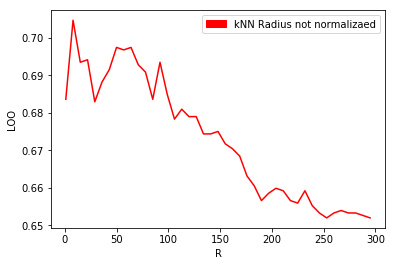

In [7]:
kNN_radius_not_normalized()

min dist = 0.0
max dist = 15840.013984403549

max acc = 0.74983454665784244


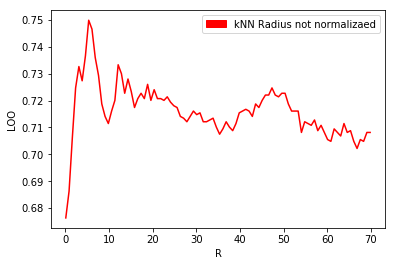

In [8]:
# kNN_radius_not_normalized(left, right, step)
kNN_radius_not_normalized(0.1, 70, 0.75)

min dist = 0.0
max dist = 15840.015903596752

max acc = 0.74983541803818299


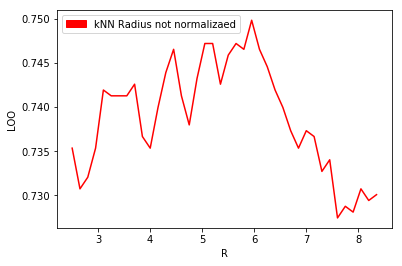

In [11]:
kNN_radius_not_normalized(2.5, 8.5, 0.15)

### Тернарный поиск
Вот тут можно искать.

In [13]:
def trenary_search(preparer, classifier, left, right, eps):
    objects, labels = preparer()
    trainingObj, trainigLabels, testObj, testLabels = extract_data(objects,
                                                                   labels)
    next_r = right + (right - left) / 2
    if right - left < eps:
        return next_r, classifier(trainingObj, trainigLabels, testObj,
                                testLabels, next_r)
    a = (left * 2 + right) / 3
    b = (left + right * 2) / 3
    acc_a = classifier(trainingObj, trainigLabels, testObj, testLabels, a)
    acc_b = classifier(trainingObj, trainigLabels, testObj, testLabels, b)
    if acc_a < acc_b:
        return trenary_search(preparer, classifier, left, b, eps)
    else:
        return trenary_search(preparer, classifier, a, right, eps)

In [15]:
opt_normal_r, opt_acc = trenary_search(prepare_data_notnorm, classify_radius, 5.5, 6.0, 0.0005)
print("optimal r = " + str(opt_normal_r))
print("opt acc = " + str(opt_acc))

optimal r = 5.978221286071424
opt acc = 0.734547820429


Найденный acc = 0.734547820429 =(

## Radius Normalized

In [16]:
#### inteface ###
def kNN_radius_normalized(r = 1.0, maximum = 200.0, step = 10.0):
    objects, labels = prepare_data_norm()
    x, y = radius_kNN(objects, labels, r, maximum, step)

    print()
    print("max acc = " + repr(max(y)))
    
    plt.ylabel('LOO')
    plt.xlabel('R')
    lb = 'kNN radius normalizaed'
    
    red_patch = mpatches.Patch(color='blue', label=lb)
    plt.legend(handles=[red_patch])


    plt.plot(x, y, label=lb, color='blue')
    plt.show() 
    

min dist = 0.0
max dist = 2.7947019207026766

max acc = 0.825147347740668


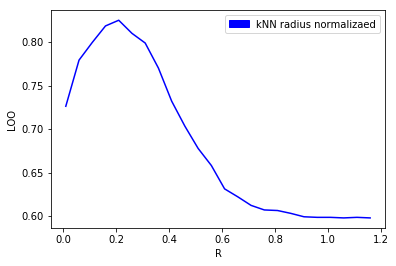

In [17]:
kNN_radius_normalized(0.01, 1.2, 0.05)

min dist = 0.0
max dist = 2.7947019207026766

max acc = 0.8274307791371539


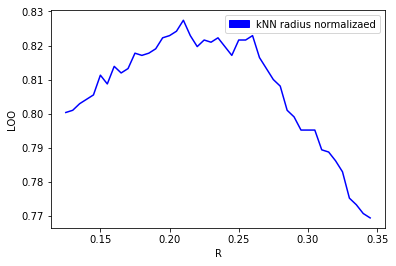

In [18]:
kNN_radius_normalized(0.125, 0.35, 0.005)

min dist = 0.0
max dist = 2.7947019207026766

max acc = 0.84199864956110737


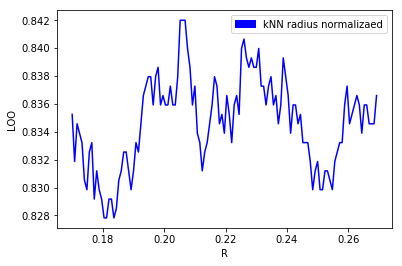

In [19]:
kNN_radius_normalized(0.17, 0.27, 0.0008)

### Тернарный поиск normalized radius


In [20]:
opt_normal_r, opt_acc = trenary_search(prepare_data_norm, classify_radius, 0.20, 0.22, 0.0005)
print("optomal r = " + str(opt_normal_r))
print("opt acc = " + str(opt_acc))

optomal r = 0.20966587071753973
opt acc = 0.823373173971


Найденный acc = 0.823373173971 =(

Конец.